<a href="https://www.kaggle.com/code/evelynartoria/encoder-emotion-classification-pytorch-nlp?scriptVersionId=188029705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import torch
from torch import nn
from transformers import AutoTokenizer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


In [3]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")
df["label"].nunique()

6

In [4]:
label_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

df["label_text"] = df["label"].map(label_dict)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


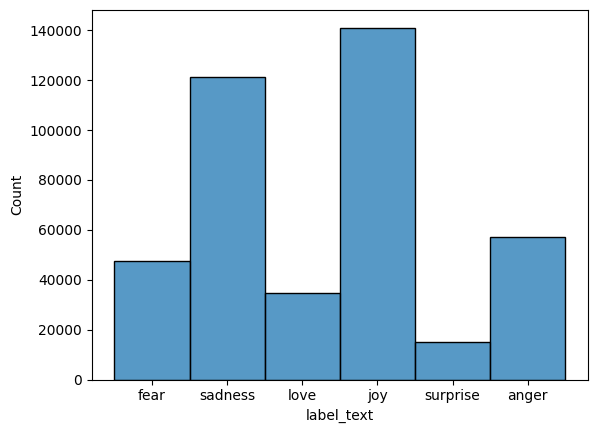

In [5]:
histogram = sns.histplot(df["label_text"], bins=df["label_text"].nunique())

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [7]:
biggest_text = max(df["text"], key=len)
max_length = len(biggest_text)
print(max_length)
simple_tokenization = tokenizer(["text", "some more text", "some more"], truncation=True, max_length=max_length, padding=True)
tokenizer.batch_encode_plus(["something", "some more text", "some more"], truncation=True, max_length=max_length, padding=True, return_token_type_ids=True)


830


{'input_ids': [[101, 26133, 102, 0, 0], [101, 11152, 10798, 15541, 102], [101, 11152, 10798, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 0, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 0]]}

In [8]:
def get_batch(df, batch_size, max_length):
    batch_sample = df.sample(n=batch_size)
    tokenized_batch = tokenizer.batch_encode_plus(
        batch_sample["text"].tolist(),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
        return_token_type_ids=True  # Ensure token_type_ids are returned
    )
    labels = torch.tensor(batch_sample["label"].tolist(), dtype=torch.long)
    return tokenized_batch, labels


In [9]:
batch_inputs, batch_labels = get_batch(df=df, batch_size=2, max_length=max_length)
print(batch_inputs["input_ids"].shape) # B, T 
print(batch_labels.shape)

torch.Size([2, 33])
torch.Size([2])


In [10]:
class FeedForward(nn.Module):
    def __init__(self, in_features, out_features, scaling_factor=4):
        super(FeedForward, self).__init__()

        self.ffwrd_layer = nn.Sequential(
            nn.Linear(in_features, in_features * scaling_factor),
            nn.ReLU(),
            nn.Linear(in_features * scaling_factor, out_features)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.ffwrd_layer(x)

In [11]:
class AttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super(AttentionHead, self).__init__()
        self.Q = nn.Linear(n_embd, head_size, bias=False)
        self.K = nn.Linear(n_embd, head_size, bias=False)
        self.V = nn.Linear(n_embd, head_size, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        q = self.Q(x) # (B, T, head_size)
        k = self.K(x) # (B, T, head_size)
        v = self.V(x) # (B, T, head_size)

        attention = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5) # (B, T, head_size) @ (B, head_size, T) --> (B, T, T)
        attention = torch.softmax(attention, dim=-1)
        x = attention @ v # (B, T, T) @ (B, T, head_size) --> (B, T, head_size)
        return x

In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, n_embd, head_size):
        super(MultiHeadedAttention, self).__init__()

        self.heads = nn.ModuleList([AttentionHead(n_embd=n_embd, head_size=head_size) for _ in range(n_heads)]) # (B, T, head_size * n_heads)
        self.projection = nn.Linear(n_heads * head_size, n_embd)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        x = torch.cat([head(x) for head in self.heads], dim=-1) # (B, T, head_size * n_heads)
        x = self.projection(x) # (B, T, n_embd)
        if mask is not None:
            x.masked_fill(~mask.unsqueeze(-1), float('-inf'))
        return x
    

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, n_heads, n_embd, head_size):
        super(TransformerBlock, self).__init__()

        self.multihead = MultiHeadedAttention(n_heads=n_heads, n_embd=n_embd, head_size=head_size)
        self.ffwrd = FeedForward(n_embd, n_embd, 4)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        x = x + self.multihead(self.layer_norm1(x), mask)
        x = x + self.ffwrd(self.layer_norm2(x))
        return x

In [14]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, n_embd, n_blocks, n_heads, head_size, context_size, n_classes):
        super(Encoder, self).__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(context_size, n_embd)

        self.blocks = nn.ModuleList([TransformerBlock(n_heads=n_heads, n_embd=n_embd, head_size=head_size) for _ in range(n_blocks)])
        self.classifier = nn.Linear(n_embd, n_classes)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        B, T = x.shape

        positions = torch.arange(start=0, end=T)
        x = self.token_embedding_table(x) + self.position_embedding_table(positions) # (B, T, C) + (T, C) --> (B, T, C)

        for block in self.blocks:
            x = block(x, mask) # (B, T, n_embd)
        x, _ = torch.max(x, dim=1) # (B, n_classes) --> get the max value
        x = self.classifier(x) # (B, n_classes)
        return x

In [15]:
vocab_size = tokenizer.vocab_size
context_size = max_length
n_classes = df["label"].nunique()

n_embd = 512
n_blocks = 10
n_heads = 8
head_size = 64
encoder = Encoder(vocab_size=vocab_size, n_embd=n_embd, n_blocks=n_blocks, n_heads=n_heads, head_size=head_size, context_size=context_size, n_classes=n_classes)

In [16]:
test_loss_fn = nn.CrossEntropyLoss()
encoder.eval()
with torch.inference_mode():
    batch_inputs, batch_labels = get_batch(df=df, batch_size=32, max_length=max_length)
    logits = encoder(batch_inputs["input_ids"], batch_inputs["attention_mask"].to(torch.bool)) # B*T, n_classes
    loss = test_loss_fn(logits, batch_labels)
    percents = torch.softmax(logits, dim=1)
    preds = torch.argmax(percents, dim=1) 
    print(f"loss of {loss}")
    print(f"model predicted --> {preds}")
    print(f"expected --> {batch_labels}")

loss of 2.2502217292785645
model predicted --> tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')
expected --> tensor([1, 3, 0, 3, 1, 0, 0, 0, 3, 2, 1, 4, 0, 1, 0, 0, 1, 0, 4, 4, 0, 0, 5, 1,
        0, 4, 0, 0, 1, 3, 5, 3], device='cuda:0')


In [17]:
def train_model(model, data, batch_size, max_length, loss_fn, optimizer, epochs):
    model.train()
    for epoch in tqdm(range(epochs)):
        batch_inputs, batch_labels = get_batch(df=df, batch_size=batch_size, max_length=max_length)
        logits = model(batch_inputs["input_ids"], batch_inputs["attention_mask"].to(torch.bool))
        loss = loss_fn(logits, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"loss for epoch {epoch} --> {loss}")

In [18]:
optimizer = torch.optim.AdamW(params=encoder.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [19]:
train_df = df.sample(frac=0.8, random_state=99)
test_df = df.drop(train_df.index)

In [20]:
train_model(model=encoder, data=train_df, batch_size=64, max_length=max_length, loss_fn=loss_fn, optimizer=optimizer, epochs=1000)

  0%|          | 1/1000 [00:00<07:56,  2.10it/s]

loss for epoch 0 --> 2.5032572746276855


  5%|▌         | 51/1000 [00:11<03:32,  4.47it/s]

loss for epoch 50 --> 1.461498737335205


 10%|█         | 102/1000 [00:22<03:12,  4.67it/s]

loss for epoch 100 --> 1.6057729721069336


 15%|█▌        | 151/1000 [00:33<03:08,  4.50it/s]

loss for epoch 150 --> 1.753842830657959


 20%|██        | 201/1000 [00:43<02:52,  4.63it/s]

loss for epoch 200 --> 1.3142865896224976


 25%|██▌       | 252/1000 [00:55<02:36,  4.77it/s]

loss for epoch 250 --> 1.154176950454712


 30%|███       | 301/1000 [01:05<02:27,  4.73it/s]

loss for epoch 300 --> 1.1977880001068115


 35%|███▌      | 351/1000 [01:16<02:22,  4.55it/s]

loss for epoch 350 --> 0.9561657905578613


 40%|████      | 401/1000 [01:27<02:08,  4.66it/s]

loss for epoch 400 --> 0.8724871277809143


 45%|████▌     | 451/1000 [01:38<02:07,  4.30it/s]

loss for epoch 450 --> 0.5799410343170166


 50%|█████     | 501/1000 [01:49<01:51,  4.47it/s]

loss for epoch 500 --> 0.6009867787361145


 55%|█████▌    | 551/1000 [01:59<01:36,  4.64it/s]

loss for epoch 550 --> 0.5439103841781616


 60%|██████    | 601/1000 [02:10<01:30,  4.43it/s]

loss for epoch 600 --> 0.6223754286766052


 65%|██████▌   | 651/1000 [02:21<01:16,  4.57it/s]

loss for epoch 650 --> 0.5819239616394043


 70%|███████   | 701/1000 [02:32<01:05,  4.57it/s]

loss for epoch 700 --> 0.509414792060852


 75%|███████▌  | 751/1000 [02:43<00:56,  4.37it/s]

loss for epoch 750 --> 0.6413676738739014


 80%|████████  | 801/1000 [02:54<00:43,  4.53it/s]

loss for epoch 800 --> 0.5343844294548035


 85%|████████▌ | 851/1000 [03:05<00:33,  4.45it/s]

loss for epoch 850 --> 0.33403462171554565


 90%|█████████ | 901/1000 [03:16<00:22,  4.39it/s]

loss for epoch 900 --> 0.49600154161453247


 95%|█████████▌| 951/1000 [03:26<00:10,  4.68it/s]

loss for epoch 950 --> 0.2860186994075775


100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


In [21]:
optimizer = torch.optim.AdamW(params=encoder.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [22]:
train_model(model=encoder, data=train_df, batch_size=64, max_length=max_length, loss_fn=loss_fn, optimizer=optimizer, epochs=1000)

  0%|          | 1/1000 [00:00<04:44,  3.52it/s]

loss for epoch 0 --> 0.3791782259941101


  5%|▌         | 51/1000 [00:11<03:23,  4.65it/s]

loss for epoch 50 --> 0.42516160011291504


 10%|█         | 101/1000 [00:22<03:19,  4.51it/s]

loss for epoch 100 --> 0.27746784687042236


 15%|█▌        | 152/1000 [00:33<02:57,  4.77it/s]

loss for epoch 150 --> 0.3798563778400421


 20%|██        | 201/1000 [00:43<02:58,  4.48it/s]

loss for epoch 200 --> 0.30338945984840393


 25%|██▌       | 251/1000 [00:54<02:41,  4.65it/s]

loss for epoch 250 --> 0.2225017249584198


 30%|███       | 301/1000 [01:05<02:22,  4.90it/s]

loss for epoch 300 --> 0.2914266884326935


 35%|███▌      | 351/1000 [01:16<02:15,  4.78it/s]

loss for epoch 350 --> 0.228693425655365


 40%|████      | 402/1000 [01:27<02:05,  4.77it/s]

loss for epoch 400 --> 0.2512247562408447


 45%|████▌     | 451/1000 [01:37<01:57,  4.67it/s]

loss for epoch 450 --> 0.20331919193267822


 50%|█████     | 501/1000 [01:48<01:46,  4.67it/s]

loss for epoch 500 --> 0.21506069600582123


 55%|█████▌    | 551/1000 [01:59<01:32,  4.87it/s]

loss for epoch 550 --> 0.3216850757598877


 60%|██████    | 601/1000 [02:09<01:25,  4.65it/s]

loss for epoch 600 --> 0.268329381942749


 65%|██████▌   | 651/1000 [02:20<01:15,  4.63it/s]

loss for epoch 650 --> 0.18925613164901733


 70%|███████   | 701/1000 [02:31<01:02,  4.76it/s]

loss for epoch 700 --> 0.2791103422641754


 75%|███████▌  | 752/1000 [02:42<00:49,  5.06it/s]

loss for epoch 750 --> 0.17334313690662384


 80%|████████  | 801/1000 [02:52<00:44,  4.42it/s]

loss for epoch 800 --> 0.22925156354904175


 85%|████████▌ | 851/1000 [03:03<00:33,  4.49it/s]

loss for epoch 850 --> 0.22376324236392975


 90%|█████████ | 902/1000 [03:14<00:20,  4.69it/s]

loss for epoch 900 --> 0.16526584327220917


 95%|█████████▌| 952/1000 [03:25<00:09,  4.86it/s]

loss for epoch 950 --> 0.2466411590576172


100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]


In [23]:
def model_inference(model, data, batch_size, n_batches, max_length, loss_fn, optimizer, debug):
    model.eval()
    batch_dict = {
        "batch_id": [],
        "acc": []
    }
    with torch.inference_mode():
        for i in range(n_batches):
            batch_inputs, batch_labels = get_batch(df=df, batch_size=batch_size, max_length=max_length)
            logits = model(batch_inputs["input_ids"])
            percents = torch.softmax(logits, dim=1)
            preds = torch.argmax(percents, dim=1)
            acc = torch.sum(preds == batch_labels)/batch_size
            if debug:
                print(f"model predicted {preds}")
                print(f"labels were {batch_labels}")
                #acc = torch.sum()
                print(f"accuracy of {acc}")

            batch_dict["batch_id"].append(i)
            batch_dict["acc"].append(acc.item())
    batch_df = pd.DataFrame(batch_dict)
    return batch_df

In [24]:
inference_data = model_inference(model=encoder, data=test_df, batch_size=32, n_batches=200, max_length=max_length, loss_fn=loss_fn, optimizer=optimizer, debug=False)

<Axes: xlabel='batch_id', ylabel='acc'>

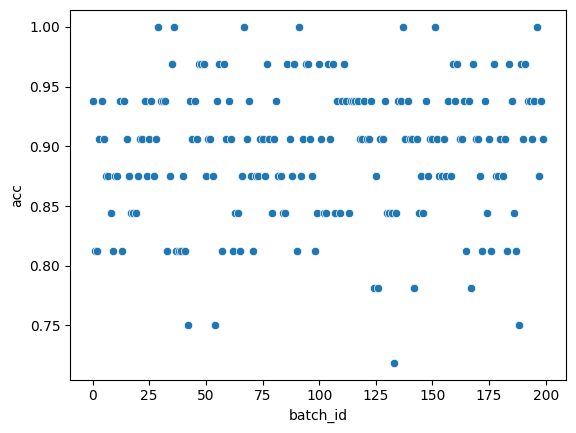

In [25]:
sns.scatterplot(data=inference_data, x="batch_id", y="acc")